# Comunicados de Política Monetaria
## Parte 1.

En este notebook crearemos un pandas DataFrame con las decisiones de política monetaria de Banxico y haremos un análisis de la información recabada.

In [1]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
from requests_html import HTMLSession
from collections import defaultdict
from unidecode import unidecode
from datetime import datetime
from tqdm.notebook import tqdm
from time import sleep
import locale
locale.setlocale(locale.LC_TIME, "es_ES.UTF-8")

'es_ES.UTF-8'

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (12, 4)

La información de decisción de política monetaria se encuentra en la siguiente url.

In [3]:
url = ("https://www.banxico.org.mx/publicaciones-y-prensa/"
      "anuncios-de-las-decisiones-de-politica-monetaria/"
      "anuncios-politica-monetaria-t.html")

* Entra a `url` y analiza la página.

In [4]:
print(url)

https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/anuncios-politica-monetaria-t.html


* Como podemos observar, la url objetivo contiene
    * las fechas de decisiones de política monetaria,
    * el resumen de las decisiones de política monetaria y
    * una url que nos dirige a un pdf con el texto completo del Anuncio de Política Monetaria.
    
<h3 style="color:crimson">Ejercicio</h3>

1. Por medio de `requests_html`, extrae los tres puntos antes mencionados y guárdalos dentro de un DataFrame con columnas `"date"`, `"text"` y `"url"`;
2. Con el dataframe seleccionado, filtra todos comunicados anteriores al 15 de febrero de 2008, i.e., queremos todos los comunicados a partir del 15 de Febrero de 2008;
3. Guarda tu DataFrame dentro de un archivo `.pkl` con nombre `comunicados-banxico.pkl`: **hint:** Revisa el uso del método `to_pickle`.

In [5]:


def extract_info(page):
    """
    Extrae todos los campos de la tabla de contenido que se encuentran en `page`
    """
    with HTMLSession() as sess:
        r = sess.get(page)
        content_table = r.html.find("table[class='table table-striped bmtableview']", first=True,)
        table = r.html.find("table[class='table table-striped bmtableview']", first=True)
        dates = content_table.find("td[tag='[current].bm:referenceDate']")
        data = table.find("td[class='bmtextview']")
        urls = table.find("a[href]")
    return dates, data, urls


def get_pdData(a,b,c):
    """
    Genera un Pandas DataFrame con los datos de fecha 'a', texto 'b' y link 'c'
    """
    values = []
    for date_temp,text_temp,link_temp in zip(a,b,c):
        date = datetime.strptime(date_temp.text, "%d/%m/%y")
        text = text_temp.text[:-15]
        link = link_temp.absolute_links.pop()
        values.append([date,text,link])
    pandita = pd.DataFrame(data=values,columns=["date","text","url"]).set_index("date")
    return pandita.loc[:'2008-02-15',:].sort_values('date')

In [6]:
fechas,textos,ligas = extract_info(url)

In [7]:
comunicados = get_pdData(fechas,textos,ligas)
comunicados.head()

,text,url
date,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...


In [8]:
comunicados.to_pickle('comunicados-banxico.pkl')

<h3 style="color:crimson">Ejercicio</h3>

Por medio del método `str.extract` para un pandas Series, crea una nueva columna `"category"` que extraiga del texto si la tasa se 
1. `"mantiene"`
2. `"incrementa"`
3. `"disminuye"`

In [9]:
comunicados = pd.read_pickle('comunicados-banxico.pkl')
regexp = re.compile("(mantiene|incrementa|disminuye)")
category = comunicados.text.str.extract(regexp)
comunicados['category'] = category
comunicados.head()

,text,url,category
date,,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,incrementa


<h3 style="color:crimson">Ejercicio</h3>

Cuenta las veces en las que la tasa se mantuvo, se incrementó o se disminuyó.

In [10]:
comunicados.category.value_counts()

mantiene      72
incrementa    18
disminuye     16
Name: category, dtype: int64

<h3 style="color:crimson">Ejercicio</h3>

Reproduce la siguiente figura sobre los comunicados de prensa de Banxico:
1. La gráfica de la izquierda representa una serie de tiempo sobre los comunicados de banxico. Si `y=1`, la tasa de referencia se incrementó; si `y=0`, la tasa se mantuvo; finalmente, si `y=-1`, la tasa disminuyó.
2. La gráfica de la derecha es una gráfica de barras del ejercicio anterior

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


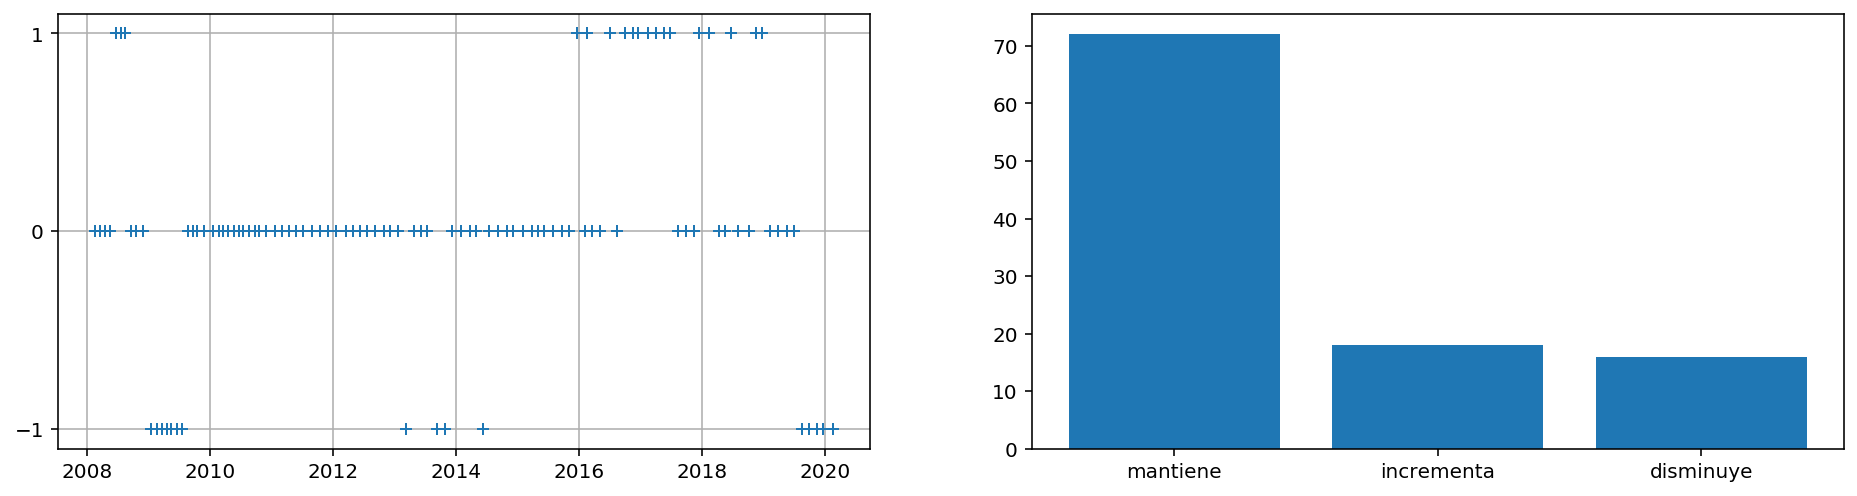

In [11]:

#Variable_name = {'mantiene' : '-' , 'incrementa' : '\u2191', 'disminuye' : '\u2193'}
Variable_name = {'mantiene' : 0 , 'incrementa' : 1, 'disminuye' : -1}
g=comunicados.category.map(Variable_name)
fig, ax = plt.subplots(ncols=2,figsize=(16, 4))
#plt.setp(ax[0], yticks=([1,0,-1],['\u2191', '-', '\u2193']))
plt.setp(ax[0], yticks=([1,0,-1]))
ax[0].grid()
ax[0].plot(g.index,g, '+')
ax[1].bar(comunicados.category.value_counts().index,comunicados.category.value_counts())
plt.show()


<h3 style="color:crimson">Ejercicio</h3>

Agrupa por año y cuenta el número de comunicados en un año para cada categoría.

In [12]:
anios=comunicados.category.groupby(comunicados.index.year).value_counts()
anios.head()

date  category  
2008  mantiene       7
      incrementa     3
2009  disminuye      7
      mantiene       4
2010  mantiene      11
Name: category, dtype: int64

<h3 style="color:crimson">Ejercicio</h3>

Con el resultado anterior, replica la siguiente gráfica

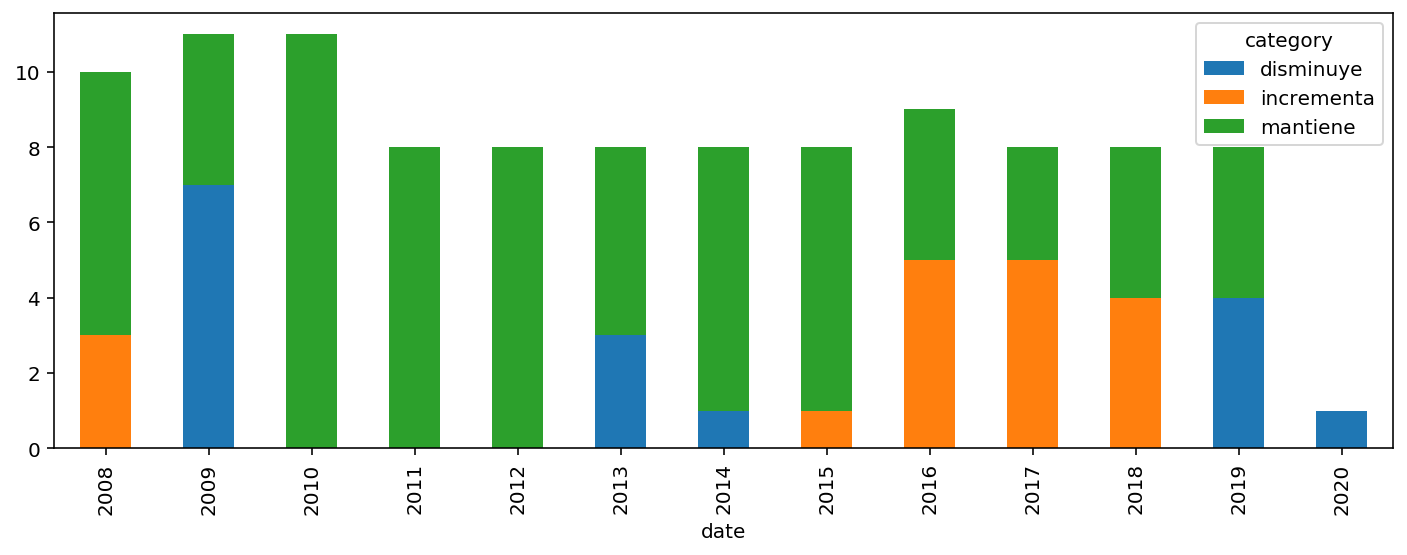

In [13]:
anios.unstack(level=1).plot.bar(stacked=True)

## La parte 2 la hice en un segundo cuaderno para poder trabajar la información de manera independente